###Task 1: Data Understanding and Visualization:

Visualizing TRAIN samples


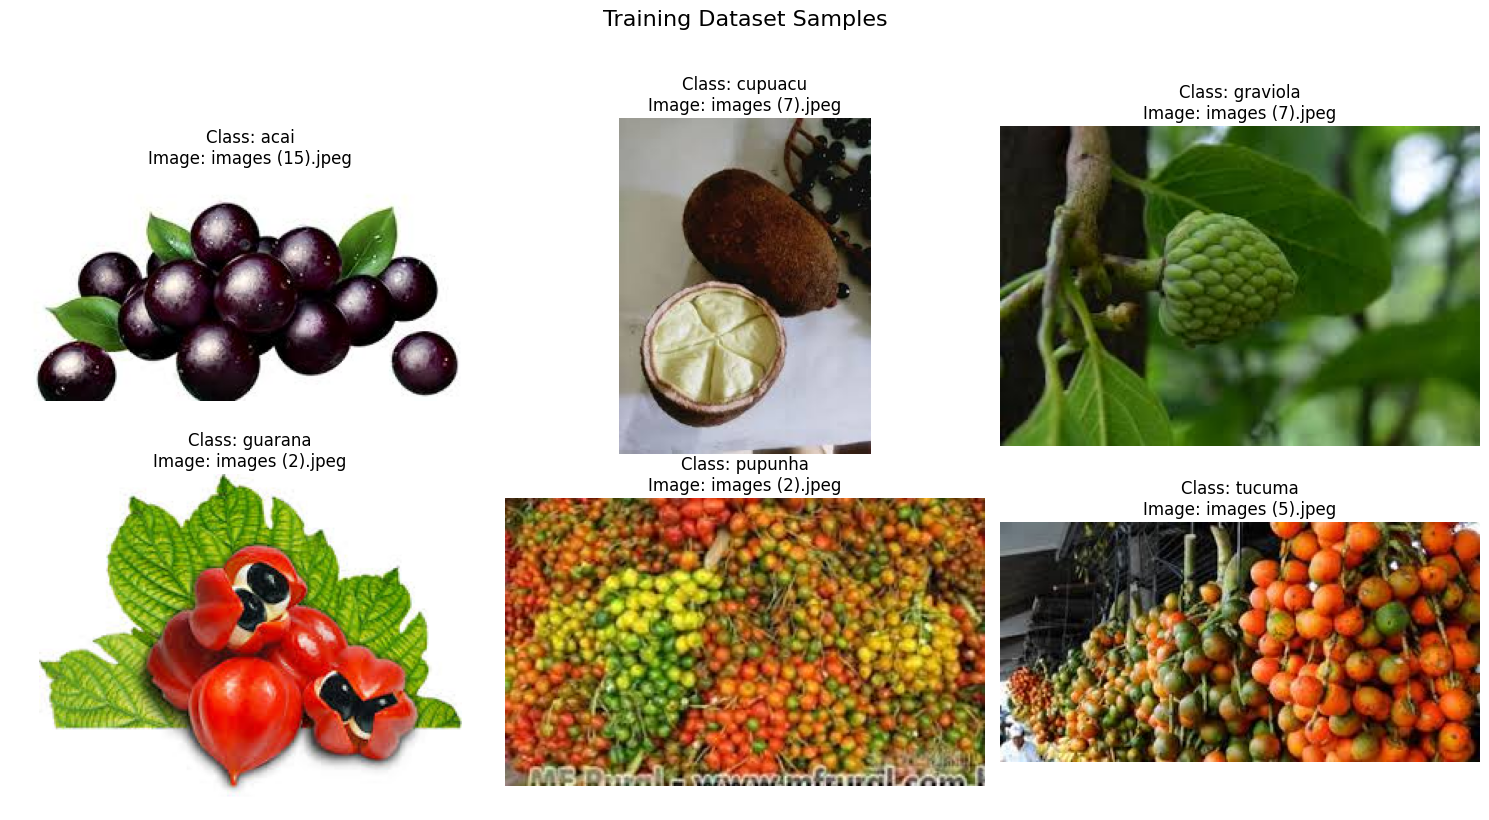

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_random_samples(train_path, test_path=None, rows=2):

    # Function to process a single directory
    def process_directory(dataset_path, title_prefix=""):
        class_dirs = sorted([d for d in os.listdir(dataset_path)
                           if os.path.isdir(os.path.join(dataset_path, d))])

        num_classes = len(class_dirs)
        cols = (num_classes + 1) // rows

        plt.figure(figsize=(15, 8))
        plt.suptitle(f"{title_prefix} Dataset Samples", y=1.02, fontsize=16)

        for i, class_dir in enumerate(class_dirs):
            class_path = os.path.join(dataset_path, class_dir)
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if not images:
                print(f"No images found in class: {class_dir}")
                continue

            random_image = random.choice(images)
            img_path = os.path.join(class_path, random_image)

            img = Image.open(img_path)

            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(img)
            ax.set_title(f"Class: {class_dir}\nImage: {random_image}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    print("Visualizing TRAIN samples")
    process_directory(train_path, "Training")

train_path = "/content/drive/MyDrive/AI/FruitinAmazon/train"
test_path = "/content/drive/MyDrive/AI/FruitinAmazon/test"

visualize_random_samples(train_path)

In [ ]:
import os
from PIL import Image
from PIL import UnidentifiedImageError

def check_and_remove_corrupted_images(dataset_path):
    """Check for and remove corrupted images in a directory tree.

    Args:
        dataset_path: Path to the root directory containing images

    Returns:
        List of paths to corrupted images that were removed
    """
    corrupted_images = []

    for root, _, files in os.walk(dataset_path):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, filename)
                try:
                    # Verify image integrity
                    with Image.open(file_path) as img:
                        img.verify()  # Verify without loading entire image
                        img.close()   # Explicit close (redundant with 'with' but safe)

                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    # Handle corrupted image
                    corrupted_images.append(file_path)
                    os.remove(file_path)
                    print(f"Removed corrupted image: {file_path} (Error: {str(e)})")

    # Final report
    if not corrupted_images:
        print("No corrupted images found.")
    else:
        print(f"\nSummary: Removed {len(corrupted_images)} corrupted images.")

    return corrupted_images


train_path = "/content/drive/MyDrive/AI/FruitinAmazon/train"
check_and_remove_corrupted_images(train_path)

No corrupted images found.


[]

###Task 2: Loading and Preprocessing Image Data in keras:

In [ ]:
import tensorflow as tf

# Define image size and batch size
img_height = 128  # Example image height
img_width = 128   # Example image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation
train_dir = "/content/drive/MyDrive/AI/FruitinAmazon/train"

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1. / 255)  # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))


# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


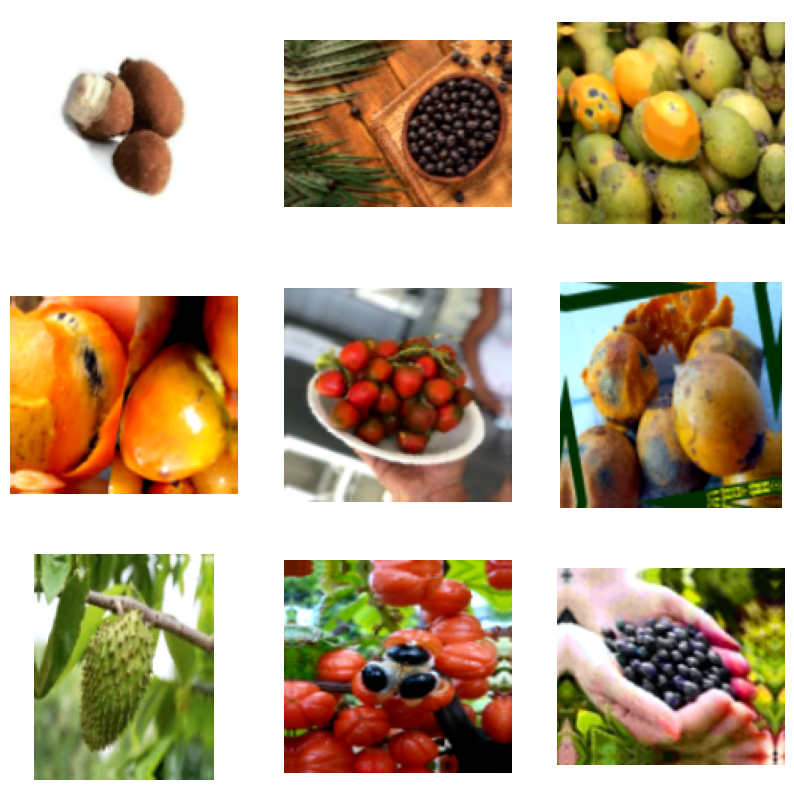

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define augmentation (simpler first)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomWidth(0.2),  # Stretch width
    layers.RandomHeight(0.2),  # Stretch height
    layers.RandomContrast(0.3),
])


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(tf.expand_dims(images[i], axis=0), training=True)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(augmented[0], 0, 1).numpy())
        plt.axis("off")
plt.show()


###Task 3 - Implement a CNN with Convolutional Architecture and Fully Connected Network Architecture:

In [ ]:
for image_batch, labels_batch in train_ds.take(1):  # Get one batch
    print(image_batch.shape)  # Prints (batch_size, height, width, channels)
    break

(32, 128, 128, 3)


In [ ]:
input_shape = (32, 128, 128, 3)

###Task 5: Complie and Train the Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

layer = Dropout(rate=0.25, noise_shape=None, seed=None)

In [ ]:
train_path = "/content/drive/MyDrive/AI/FruitinAmazon/train"
class_names = sorted([d for d in os.listdir(train_path)
                    if os.path.isdir(os.path.join(train_path, d))])
print("Class names:", class_names)

Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = len(class_names)

# Define the model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None, input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),

    # Output Layer
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,802 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

### Task 6: Evaluate the Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation


inputs = keras.Input(shape=input_shape)

# Compile the model
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=8,
    epochs=2000,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


model.summary()

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.6291 - loss: 0.8198

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6350 - loss: 0.8087 - val_accuracy: 0.5556 - val_loss: 1.3010
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.6395 - loss: 0.8307

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.6428 - loss: 0.8264 - val_accuracy: 0.7222 - val_loss: 1.1564
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7826 - loss: 0.5926 - val_accuracy: 0.6111 - val_loss: 1.2579
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step - accuracy: 0.7461 - loss: 0.5843 - val_accuracy: 0.5556 - val_loss: 1.3271
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.8641 - loss: 0.4230 - val_accuracy: 0.2778 - val_loss: 1.7905
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7834 - loss: 0.6022 - val_accuracy: 0.6111 - val_loss: 1.2080
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.7645 - loss: 0.4983

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 983ms/step - accuracy: 0.7678 - loss: 0.4924 - val_accuracy: 0.6667 - val_loss: 1.0864
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 888ms/step - accuracy: 0.7374 - loss: 0.5337 - val_accuracy: 0.6111 - val_loss: 1.2266
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7135 - loss: 0.6437 - val_accuracy: 0.5000 - val_loss: 1.2852
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - accuracy: 0.8581 - loss: 0.4912 - val_accuracy: 0.6111 - val_loss: 1.1768
Epoch 11/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 944ms/step - accuracy: 0.7912 - loss: 0.5071 - val_accuracy: 0.5556 - val_loss: 1.3515
Epoch 12/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8190 - loss: 0.4022 - val_accuracy: 0.2778 - val_loss: 1.4174


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,804 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6667 - loss: 1.0864
Validation Loss: 1.0864
Validation Accuracy: 0.6667


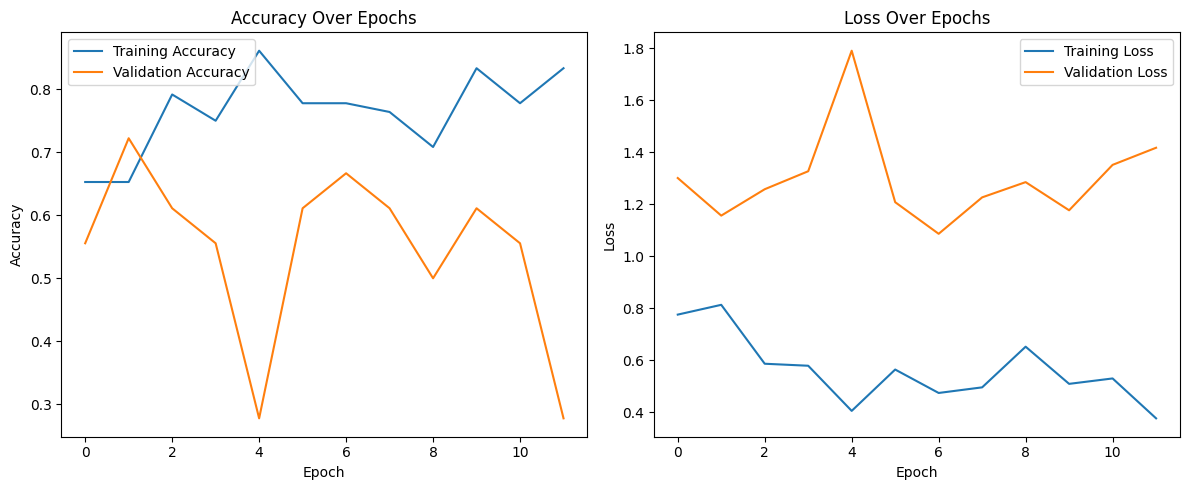

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()